# 🐱 CatBoost Tutorial – Handling Categorical Features in Boosting
**Dataset**: Bank Marketing Dataset

In this notebook, we will:
- Perform EDA on the dataset
- Preprocess categorical and numerical features
- Train a `CatBoostClassifier`
- Evaluate performance (ROC, Confusion Matrix, Report)
- Visualize Feature Importance

In [7]:
!pip install --force-reinstall catboost

  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.

In [8]:
!pip install --upgrade numpy

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
^C


In [9]:
pip install catboost

^C


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade scipy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

## 📥 Load Dataset

In [2]:
# Load dataset (already uploaded)
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 📊 Basic Info and Class Distribution

In [3]:
df.info()
df['y'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,proportion
y,
no,0.887346
yes,0.112654


## 🧹 Preprocessing – Convert Target & Identify Categorical Columns

In [4]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

## ✂️ Train-Test Split

In [5]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 🧠 Train CatBoostClassifier

In [6]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_cols,
    verbose=100,
    random_seed=42,
    eval_metric='AUC'
)
model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test))

0:	test: 0.9208382	best: 0.9208382 (0)	total: 238ms	remaining: 1m 58s
100:	test: 0.9543715	best: 0.9543869 (99)	total: 22.8s	remaining: 1m 30s
200:	test: 0.9559163	best: 0.9559708 (199)	total: 45.8s	remaining: 1m 8s
300:	test: 0.9563507	best: 0.9563507 (300)	total: 53.7s	remaining: 35.5s
400:	test: 0.9565288	best: 0.9565293 (398)	total: 1m 2s	remaining: 15.5s
499:	test: 0.9563690	best: 0.9565653 (404)	total: 1m 10s	remaining: 0us

bestTest = 0.9565653156
bestIteration = 404

Shrink model to first 405 iterations.


## 📈 Evaluation – Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7310
           1       0.69      0.57      0.63       928

    accuracy                           0.92      8238
   macro avg       0.82      0.77      0.79      8238
weighted avg       0.92      0.92      0.92      8238



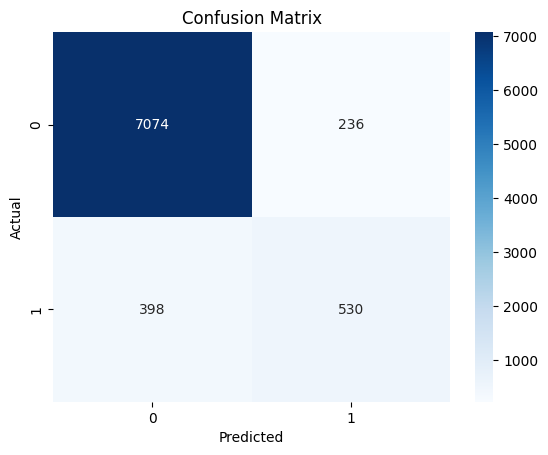

In [7]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 📉 ROC Curve and AUC

ROC AUC Score: 0.9566


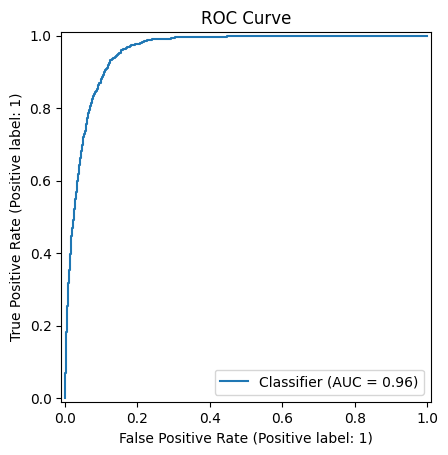

In [8]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')
plt.show()

## 🔍 Feature Importance (CatBoost Built-in)

In [9]:
feature_importance = model.get_feature_importance()
feature_names = X.columns
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
fi_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
10,duration,50.163203
18,euribor3m,10.927418
15,emp.var.rate,8.095018
19,nr.employed,6.380883
8,month,5.229713
17,cons.conf.idx,3.141619
7,contact,2.865938
16,cons.price.idx,2.492734
3,education,1.864707
0,age,1.503753


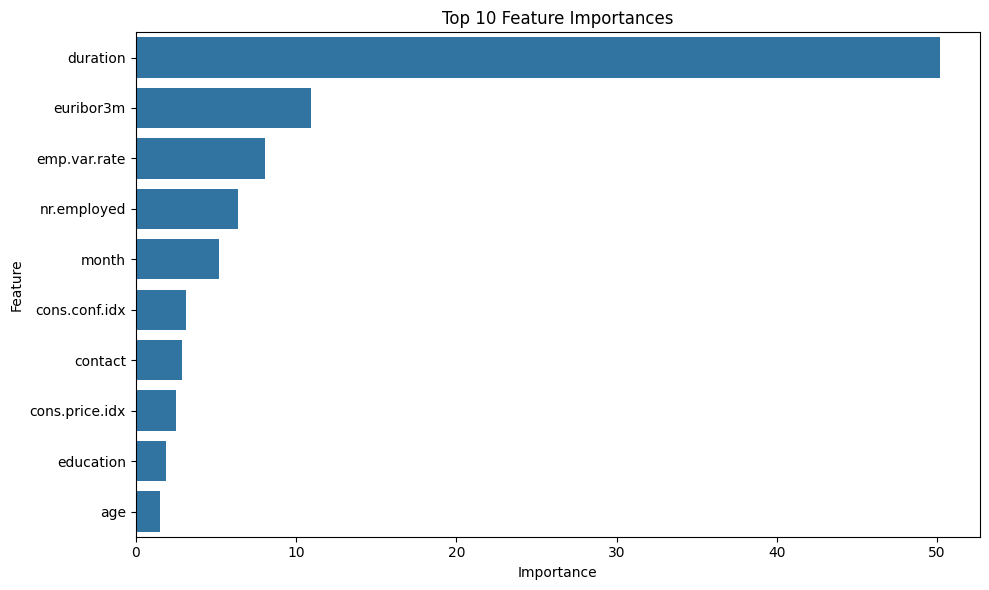

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=fi_df.sort_values(by='Importance', ascending=False).head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()